In [33]:
from PIL import Image
import io



def request_image_path():
    return input("Please enter the path to the image file: ")


def decide_model(image):
    # Calculate the aspect ratio of the image

    aspect_ratio = image.size[0] / image.size[1]
    mode = ""
    # Determine the closest model based on aspect ratio
    if aspect_ratio < 0.75:
        return 0
    elif aspect_ratio < 1:
        return 1
    elif aspect_ratio < 1.5:
        return 2
    elif aspect_ratio < 1.85:
        return 3
    else:
        return 4


def process_image(image_path):
    try:
        image = Image.open(image_path)
        print(f"Image {image_path} loaded successfully.")
    except FileNotFoundError:
        print(
            f"File {image_path} not found, please try supplying the correct and full path.")
    except Exception as e:
        print(f"Error opening image: {e}")


image_path = request_image_path()
process_image(image_path)

Image D:\Devlopment\airphotos\imgs\satellite_3.png loaded successfully.


In [34]:
# Decide which model to use based on the aspect ratio of the image

import os

OUTPUT_DIR = "./image_outputs"

# Define the relative path
MODEL_PATHS = [r"WALDO_25_RELEASE_2\WALDO25_FOSS\V7-base\square\yolov7-W25-416-newDefaults-bs196\weights\ONNX-runtime-models-batch-size-1\yolov7-W25-416px-newDefaults-bs196-best-topk-200.onnx"
,r"WALDO_25_RELEASE_2\WALDO25_FOSS\V7-base\square\yolov7-W25-512-newDefaults-bs144\weights\ONNX-runtime-models-batch-size-1\yolov7-W25-512px-newDefaults-bs144-best-topk-200.onnx"
,r"WALDO_25_RELEASE_2\WALDO25_FOSS\V7-base\square\yolov7-W25-736-newDefaults-bs196\weights\ONNX-runtime-models-batch-size-1\yolov7-W25-736px-newDefaults-bs196-best-topk-200.onnx"
,r"WALDO_25_RELEASE_2\WALDO25_FOSS\V7-base\square\yolov7-W25-1088-newDefaults-bs96\weights\ONNX-runtime-models-batch-size-1\yolov7-W25-1088px-newDefaults-bs96-best-topk-200.onnx"
,r"WALDO_25_RELEASE_2\WALDO25_FOSS\V7-base\square\yolov7-W25-960-newDefaults-bs144\weights\ONNX-runtime-models-batch-size-1\yolov7-W25-960px-newDefaults-bs144-best-topk-200.onnx"
]

image = Image.open(image_path)
model_path = MODEL_PATHS[decide_model(image)]
current_path = os.getcwd()

# Combine the current working directory with the relative path
full_model_path = os.path.join(current_path, model_path)

# Print the full path
print(full_model_path)

d:\Devlopment\airphotos\src\WALDO_25_RELEASE_2\WALDO25_FOSS\V7-base\square\yolov7-W25-416-newDefaults-bs196\weights\ONNX-runtime-models-batch-size-1\yolov7-W25-416px-newDefaults-bs196-best-topk-200.onnx


Params = 2.958152MB, FLOP = 10.445718GB
(1467, 1082, 3) from fetch data
(1467, 1082, 3)


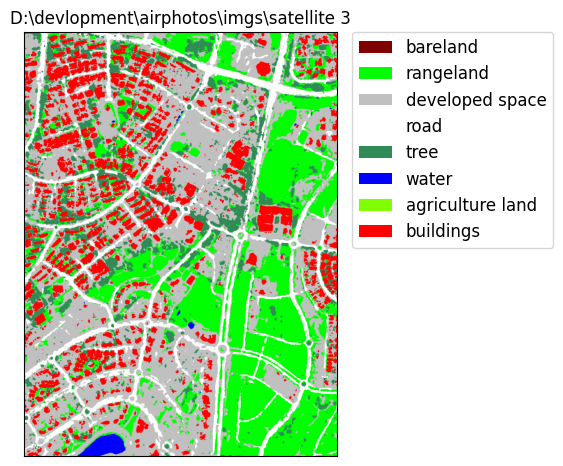

In [35]:
# SparseMask Model

import torch
from thop import profile

from config import config
from oem_lightweight.evaluator import SegEvaluator
from oem_lightweight.utils import prepare_data
from oem_lightweight.model import sparsemask

MASK_PATH = "models/SparseMask/mask_thres_0.001.npy"
WEIGHTS_PATH = "models/SparseMask/checkpoint_63750.pth"


model = sparsemask(mask=MASK_PATH, weights=WEIGHTS_PATH)


# check number of parameters and flops
flop, params = profile(model["model"], inputs=(torch.randn(1, 3, 1024, 1024),), verbose=False)
print("Params = %fMB, FLOP = %fGB" % (params / 1e6, flop / 1e9))

# prepare the data
image = image_path
label = image_path
data = prepare_data(img_file=image, label_file=label)


# init evaluator
print(data["img"].shape)
evaluator = SegEvaluator(config, data, model)

# preform evaluation
result = evaluator.evaluate()


# plot and save image
evaluator.show_predicted_image(result, only_pred=True, save_img=True, save_dir=OUTPUT_DIR)



In [36]:
# WALDO Model

import math
import cv2
import time
import requests
import random
import numpy as np
import torch
import onnxruntime as ort
from PIL import Image
from pathlib import Path
from collections import OrderedDict,namedtuple
import re
import os
import argparse


def get_resolution_from_model_path(model_path):
    resolution = re.search(r"(\d+)px", model_path)
    if resolution:
        return int(resolution.group(1))
    return None




def letterbox(im, new_shape=(960, 960), color=(114, 114, 114), auto=True, scaleup=True, stride=32):
    # Resize and pad image while meeting stride-multiple constraints
    shape = im.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better val mAP)
        r = min(r, 1.0)

    # Compute padding
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding

    if auto:  # minimum rectangle 
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding

    dw /= 2  # divide padding into 2 sides
    dh /= 2
    

    if shape[::-1] != new_unpad:  # resize
        im = cv2.resize(im, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return im, r, (dw, dh)

def split_image(image, tile_size=(960, 960)):
    height, width, _ = image.shape
    tile_height, tile_width = tile_size


    # Calculate the number of tiles needed in each dimension
    num_tiles_x = math.ceil(width / tile_width)
    num_tiles_y = math.ceil(height / tile_height)

    # Copy the original image to prevent modifying it
    temp_image = image.copy()

    # Split the image into tiles
    tiles = []
    for y in range(num_tiles_y):
        for x in range(num_tiles_x):
            tile = temp_image[
                y * tile_height : (y + 1) * tile_height,
                x * tile_width : (x + 1) * tile_width,
                :,
            ]
            tiles.append(((x, y), tile))

    return tiles, temp_image.shape[:2]

def merge_tiles(tiles, output_shape):
    tile_height, tile_width = tiles[0][1].shape[:2]
    num_tiles_x = output_shape[1] // (tile_width)
    num_tiles_y = output_shape[0] // (tile_height)

    merged_image = np.zeros((*output_shape, 3), dtype=np.uint8)

    for (x, y), tile in tiles:
        tile_no_padding = tile
        merged_image[
            y * (tile_height) : (y + 1) * (tile_height),
            x * (tile_width) : (x + 1) * (tile_width),
            :,
        ] = tile_no_padding

    return merged_image





def process_and_annotate_large_images(image, second_image, model, resize_image=False):

    # set cuda = true if you have an NVIDIA GPU
    cuda = torch.cuda.is_available()

    w = model
    
    names = ['car', 'van', 'truck', 'building', 'human', 'gastank', 'digger', 'container', 'bus', 'u_pole', 'boat', 'bike', 'smoke',
             'solarpanels', 'arm', 'plane']

    colors = {name:[random.randint(0, 255) for _ in range(3)] for i,name in enumerate(names)}

    img = image

    providers = ['CUDAExecutionProvider', 'CPUExecutionProvider'] if cuda else ['CPUExecutionProvider']
    session = ort.InferenceSession(w, providers=providers)
    
    outname = [i.name for i in session.get_outputs()]
    outname
    
    inname = [i.name for i in session.get_inputs()]
    
    
    resolution = get_resolution_from_model_path(model)
    if resolution is None:
        print("Warning: Model resolution not found in the model path. Defaulting to 960px.")
        resolution = 960

    tile_size = (resolution, resolution)  # move this line here

    # Split the image into tiles
    tiles, padded_shape = split_image(image, tile_size=tile_size)
    second_image_tiles, second_image_padded_shape = split_image(second_image, tile_size=tile_size)

    # Initialize a dictionary to store the count of each category
    category_count = {name: 0 for name in names}

    # Process each tile with the ONNX model
    processed_tiles = []
    for i, ((tile_idx, tile), (_, second_tile)) in enumerate(zip(tiles, second_image_tiles)):
        image = tile.copy()
        image, ratio, dwdh = letterbox(image, new_shape=tile_size, auto=False)
        image = image.transpose((2, 0, 1))
        image = np.expand_dims(image, 0)
        image = np.ascontiguousarray(image)

        im = image.astype(np.float32)
        im /= 255

        inp = {inname[0]: im}
        outputs = session.run(outname, inp)[0]

        for i, (batch_id, x0, y0, x1, y1, cls_id, score) in enumerate(outputs):
            box = np.array([x0, y0, x1, y1])
            box -= np.array(dwdh * 2)
            box /= ratio
            box = box.round().astype(np.int32).tolist()
            cls_id = int(cls_id)
            score = round(float(score), 3)
            name = names[cls_id]
            color = colors[name]
            name += ' ' + str(score)
            cv2.rectangle(tile, box[:2], box[2:], color, 2)
            cv2.putText(tile, name, (box[0], box[1] - 2), cv2.FONT_HERSHEY_SIMPLEX, 0.75, [225, 255, 255], thickness=2)
            # The additional image
            cv2.rectangle(second_tile, box[:2], box[2:], color, 2)
            #cv2.putText(second_tile, name, (box[0], box[1] - 2), cv2.FONT_HERSHEY_SIMPLEX, 0.75, [225, 255, 255], thickness=2)

            # Update the count for the detected category
            category_count[name.split()[0]] += 1

        processed_tiles.append((tile_idx, tile))

    # Merge the processed tiles back into the original image
    merged_image = merge_tiles(processed_tiles, padded_shape)
    merged_second_image = merge_tiles(second_image_tiles, second_image_padded_shape)
    # Remove padding from the merged image to get the final output
    final_image = merged_image[: img.shape[0], : img.shape[1], :]
    final_second_image = merged_second_image[: second_image.shape[0], : second_image.shape[1], :]


    outputs_array = []
    # Print the total count of each class
    print("Total count of each class:")
    for name, count in category_count.items():
        print(f"{name}: {count}")
        outputs_array.append(f"{name}: {count}")

        return final_image, final_second_image, str(outputs_array), colors, names
    
second_image = cv2.cvtColor(cv2.imread(os.path.join(os.getcwd(),OUTPUT_DIR,("SparseMask"+os.path.basename(image_path)))), cv2.COLOR_BGR2RGB)
image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
final_image, final_second_image, outputs, colors, names = process_and_annotate_large_images(image, second_image, full_model_path)


if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)
# Write the result to the output directory
print(os.path.join(OUTPUT_DIR, os.path.basename(image_path)))
cv2.imwrite(os.path.join(OUTPUT_DIR, "WALDO"+os.path.basename(image_path)), cv2.cvtColor(final_image, cv2.COLOR_RGB2BGR))
cv2.imwrite(os.path.join(OUTPUT_DIR, "WALDOANDSparseMask"+os.path.basename(image_path)), cv2.cvtColor(final_second_image, cv2.COLOR_RGB2BGR))
# Write the output counts to a text file
with open(os.path.join(OUTPUT_DIR, os.path.basename(image_path).replace('.jpg', '.txt').replace('.png', '.txt')), 'w') as file:
    file.write(outputs) 


Total count of each class:
car: 29
./image_outputs\satellite_3.png


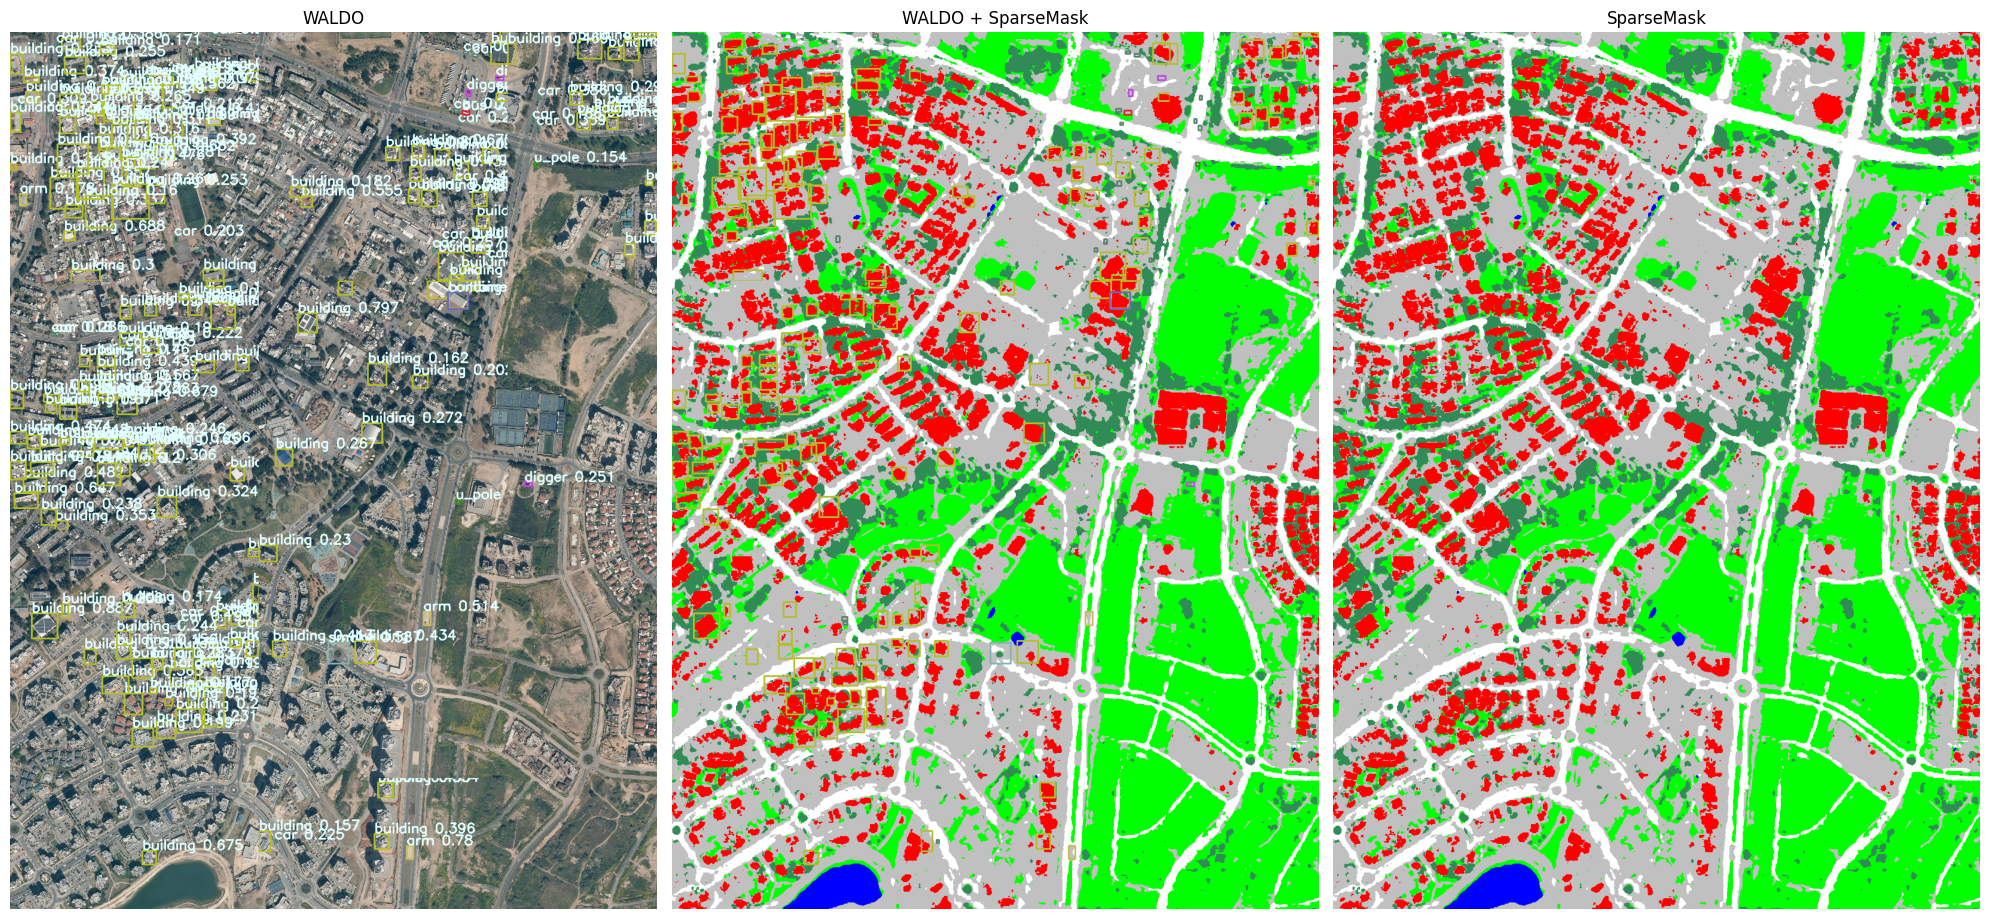

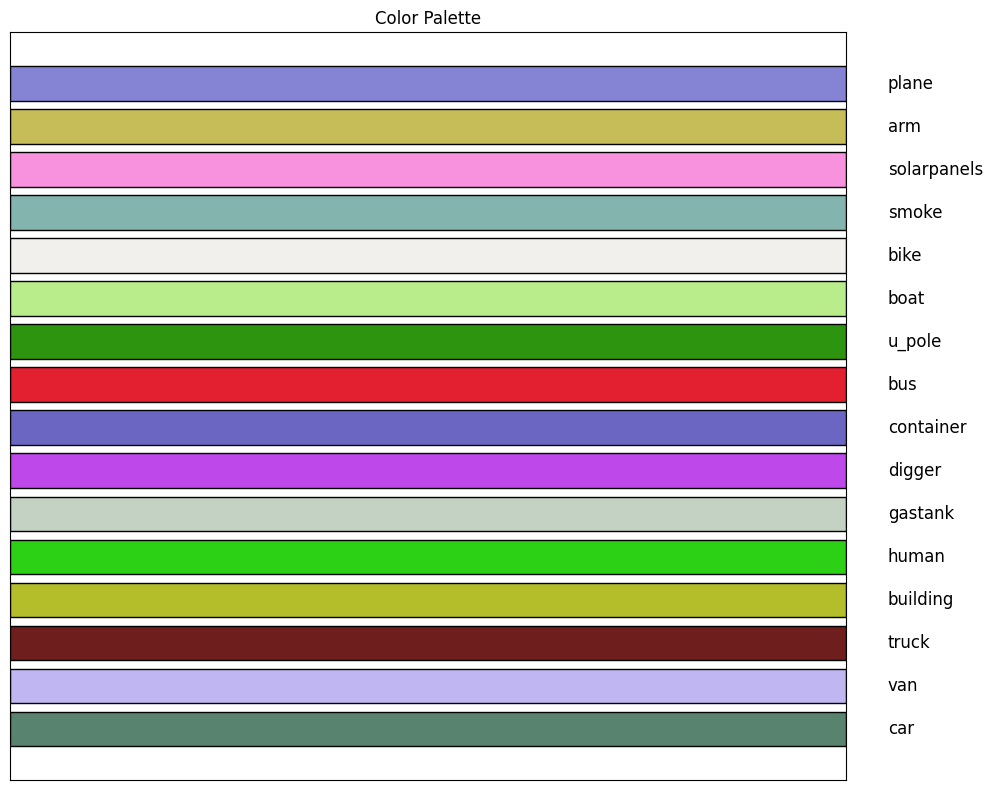

In [37]:
IMAGES_TO_RENDER = [os.path.join(OUTPUT_DIR, "WALDO"+os.path.basename(image_path)),
                    os.path.join(OUTPUT_DIR, "WALDOANDSparseMask"+os.path.basename(image_path)),
                    os.path.join(OUTPUT_DIR, "SparseMask"+os.path.basename(image_path))]

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(20, 10))

for ax, img_path, title in zip(axes, IMAGES_TO_RENDER, ["WALDO", "WALDO + SparseMask", "SparseMask"]):
    img = Image.open(img_path)
    ax.imshow(img)
    ax.set_title(title)
    ax.axis('off')
    
plt.tight_layout()
plt.show()

# Plot the color legend
fig, ax = plt.subplots(figsize=(10, 8))
for i, (name, color) in enumerate(colors.items()):
    ax.barh(i, 1, color=[c/255 for c in color], edgecolor='black')
    ax.text(1.05, i, name, va='center', ha='left', fontsize=12)

ax.set_xlim(0, 1)
ax.set_yticks([])
ax.set_xticks([])
ax.set_title("Color Palette")
plt.tight_layout()
plt.show()
